# Setup enviorment

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""
embeddings = None
temp_prec = ['../Tabular_data/precipitation_all.csv', '../Tabular_data/temperature_all 2.csv']
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv('Embeddings/variational_autoencoder_224_1024.csv')['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality, temp_prec=temp_prec) for Municipality in Municipalities]
type(dengue_df)

list

### Train Test split

In [4]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)


### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

temperature  precipitation    Labels
41001 201546    -0.214918       0.717409  0.064361
      201547    -0.699029      -0.201813  0.091926
      201548     0.476415       0.142851  0.082738
      201549     1.031855      -0.733771  0.082738
      201550     0.636574       0.782050  0.211376

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

temperature  precipitation    Labels
41001 201820    -0.879642      -0.063182 -0.275610
      201821    -0.495573       0.091043 -0.321552
      201822    -1.183651      -0.006134 -0.238856
      201823    -1.271677      -0.732817 -0.321552
      201824    -0.804984      -0.624895 -0.293986

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(128, 7)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [10]:
train.shape

(1280, 7)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1280, 6)
The shape of the labels is (1280, 1)
Test:
The shape of the features is (310, 6)
The shape of the labels is (310, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1280, 6)
The test shape is (310, 6)
-----------------------
The Final shapes are:
The train shape is (1280, 3, 2)
The test shape is (310, 3, 2)


# 2. Model

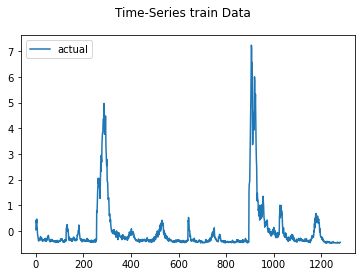

2023-03-14 19:39:38.465758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 19:39:38.465817: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 19:39:38.465850: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-14 19:39:38.466103: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 19:39:40.382287: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 30.515
Test RMSE: 37.648
Test sMAPE: 86.421
Test R Squared: -0.429
{'mae': 30.51492434951567, 'rmse': 37.64794667300621, 'smape': 86.42086321329188, 'r2': -0.4286226253068881}


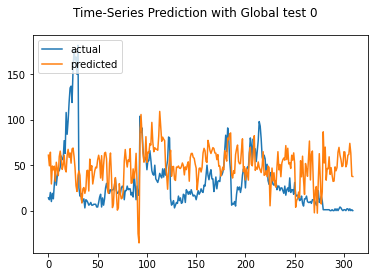

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 22.297
Test RMSE: 31.208
Test sMAPE: 73.724
Test R Squared: 0.018
{'mae': 22.296645779763498, 'rmse': 31.207974894311917, 'smape': 73.72352782177674, 'r2': 0.01832866351887119}


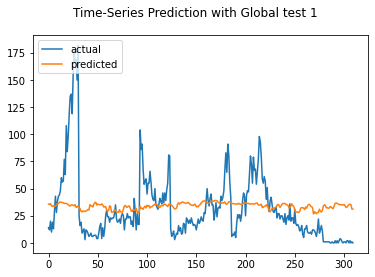

Test MAE: 34.059
Test RMSE: 41.090
Test sMAPE: 94.507
Test R Squared: -0.702
{'mae': 34.05875419830122, 'rmse': 41.089686464386965, 'smape': 94.50686589996309, 'r2': -0.7017689260073141}


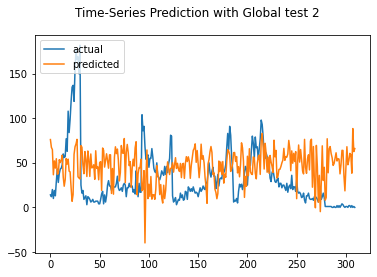

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 29.776
Test RMSE: 35.595
Test sMAPE: 85.268
Test R Squared: -0.277
{'mae': 29.775631972282163, 'rmse': 35.5950612792246, 'smape': 85.26773851549991, 'r2': -0.2770691810043828}


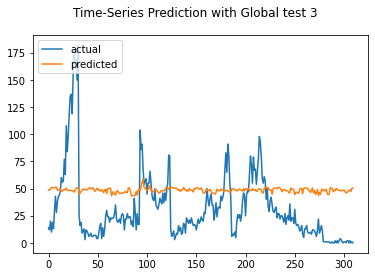

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 27.134
Test RMSE: 34.928
Test sMAPE: 86.721
Test R Squared: -0.230
{'mae': 27.13360303659593, 'rmse': 34.92755506961534, 'smape': 86.72070461287123, 'r2': -0.22962109910447626}


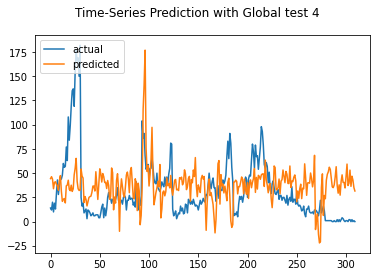

Test MAE: 37.238
Test RMSE: 48.874
Test sMAPE: 105.972
Test R Squared: -1.408
{'mae': 37.23814420671232, 'rmse': 48.87406614450823, 'smape': 105.97158570204596, 'r2': -1.4076418239581225}


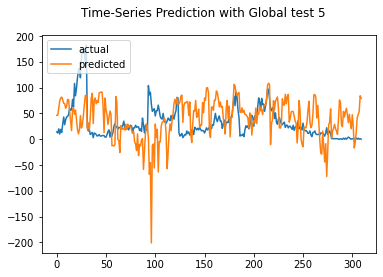

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 27.778
Test RMSE: 36.094
Test sMAPE: 82.685
Test R Squared: -0.313
{'mae': 27.777685045667234, 'rmse': 36.09362289943046, 'smape': 82.68547638216671, 'r2': -0.31309421394803416}


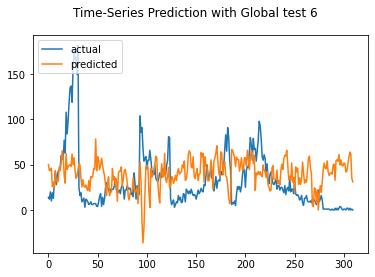

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 23.156
Test RMSE: 31.358
Test sMAPE: 72.873
Test R Squared: 0.009
{'mae': 23.156393321867913, 'rmse': 31.358440422806655, 'smape': 72.87294816011061, 'r2': 0.008839821357647937}


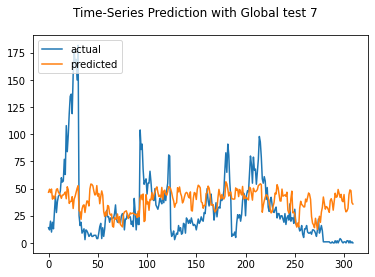

Test MAE: 38.409
Test RMSE: 49.858
Test sMAPE: 112.052
Test R Squared: -1.506
{'mae': 38.40945922487205, 'rmse': 49.85813326373858, 'smape': 112.05235791325127, 'r2': -1.5055724356247397}


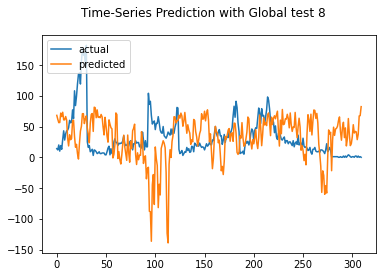

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 30.636
Test RMSE: 36.903
Test sMAPE: 85.685
Test R Squared: -0.373
{'mae': 30.63629778046762, 'rmse': 36.902711808803744, 'smape': 85.68532891668477, 'r2': -0.3726237141703703}


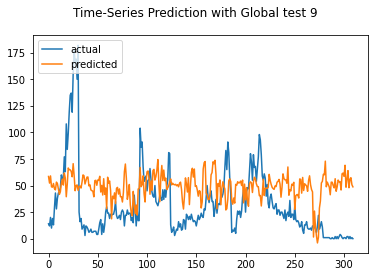

Test MAE: 34.024
Test RMSE: 42.348
Test sMAPE: 100.703
Test R Squared: -0.808
{'mae': 34.02381200675041, 'rmse': 42.348277852307994, 'smape': 100.7030938052467, 'r2': -0.8076171047990914}


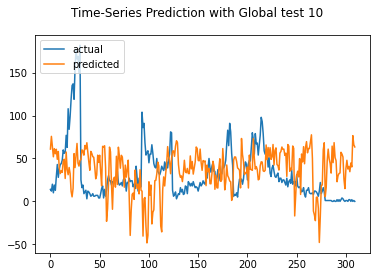

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 28.956
Test RMSE: 36.379
Test sMAPE: 85.209
Test R Squared: -0.334
{'mae': 28.955713797384693, 'rmse': 36.379147204554236, 'smape': 85.2088121452879, 'r2': -0.3339512638056601}


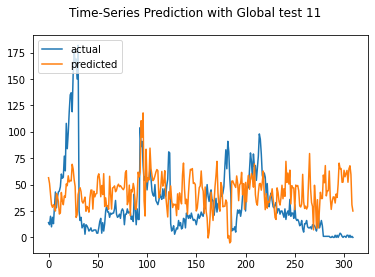

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 27.219
Test RMSE: 35.297
Test sMAPE: 85.164
Test R Squared: -0.256
{'mae': 27.21927852803661, 'rmse': 35.29685654684259, 'smape': 85.1643866662666, 'r2': -0.2557610091334812}


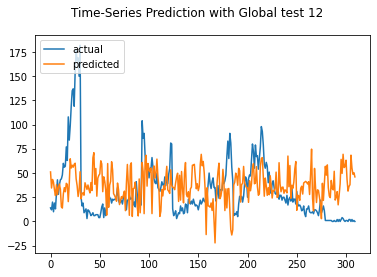

Test MAE: 35.389
Test RMSE: 43.852
Test sMAPE: 94.723
Test R Squared: -0.938
{'mae': 35.389070510095166, 'rmse': 43.85201397143663, 'smape': 94.72327049076466, 'r2': -0.9382688760987106}


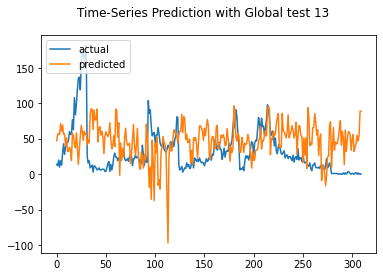

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 25.496
Test RMSE: 33.088
Test sMAPE: 80.041
Test R Squared: -0.103
{'mae': 25.4964289880568, 'rmse': 33.08765957201716, 'smape': 80.04129436581647, 'r2': -0.1034865194989194}


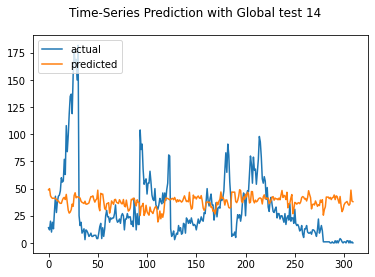

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 22.297
Test RMSE: 31.286
Test sMAPE: 74.040
Test R Squared: 0.013
{'mae': 22.297200301385693, 'rmse': 31.285533981842956, 'smape': 74.04049950136663, 'r2': 0.0134432364365914}


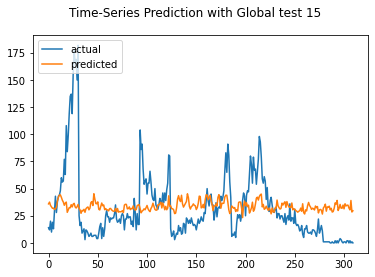

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 29.547
Test RMSE: 36.990
Test sMAPE: 86.187
Test R Squared: -0.379
{'mae': 29.546768456889737, 'rmse': 36.989812735466266, 'smape': 86.18674881582825, 'r2': -0.3791109280183189}


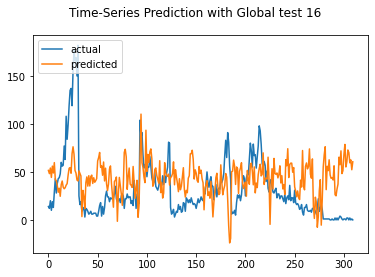

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 32.267
Test RMSE: 37.458
Test sMAPE: 88.528
Test R Squared: -0.414
{'mae': 32.266909211681735, 'rmse': 37.4577861768492, 'smape': 88.5282253403866, 'r2': -0.4142270732454305}


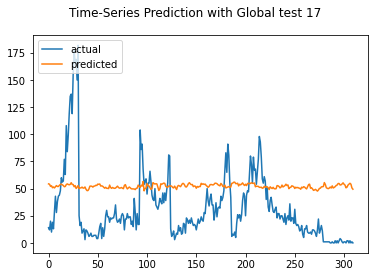

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 22.419
Test RMSE: 31.445
Test sMAPE: 73.356
Test R Squared: 0.003
{'mae': 22.419398301647554, 'rmse': 31.445036420513933, 'smape': 73.3558477893407, 'r2': 0.003358106488643098}


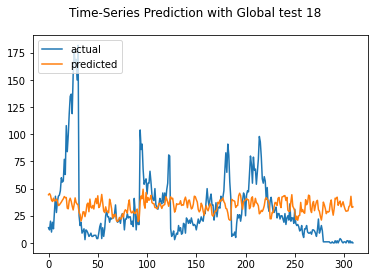

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 30.856
Test RMSE: 36.288
Test sMAPE: 86.927
Test R Squared: -0.327
{'mae': 30.85614105962938, 'rmse': 36.28802071945853, 'smape': 86.92673238224525, 'r2': -0.327276778392549}


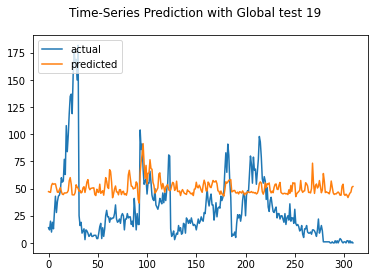

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 21.910
Test RMSE: 30.853
Test sMAPE: 71.593
Test R Squared: 0.041
{'mae': 21.90954425565658, 'rmse': 30.853462145919423, 'smape': 71.59261504488465, 'r2': 0.040504939574396714}


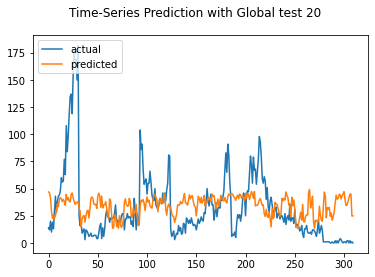

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 29.150
Test RMSE: 36.914
Test sMAPE: 94.233
Test R Squared: -0.373
{'mae': 29.149548768083896, 'rmse': 36.913893060048004, 'smape': 94.23308276468833, 'r2': -0.37345563003630056}


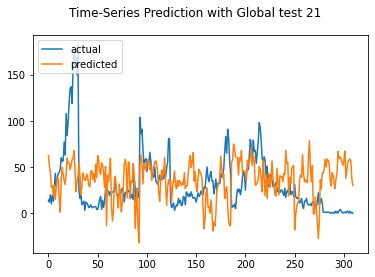

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 26.466
Test RMSE: 34.945
Test sMAPE: 79.341
Test R Squared: -0.231
{'mae': 26.46623989382098, 'rmse': 34.94492248750742, 'smape': 79.3413592299615, 'r2': -0.230844239562624}


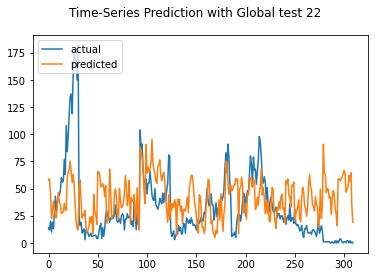

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 26.414
Test RMSE: 32.859
Test sMAPE: 80.569
Test R Squared: -0.088
{'mae': 26.414319241431453, 'rmse': 32.85942290159803, 'smape': 80.56922364777179, 'r2': -0.08831545885032033}


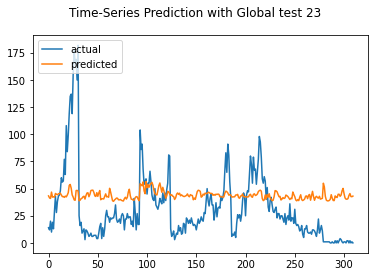

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 29.674
Test RMSE: 36.922
Test sMAPE: 89.268
Test R Squared: -0.374
{'mae': 29.673786895746186, 'rmse': 36.922434081521864, 'smape': 89.26755309718044, 'r2': -0.3740912753267318}


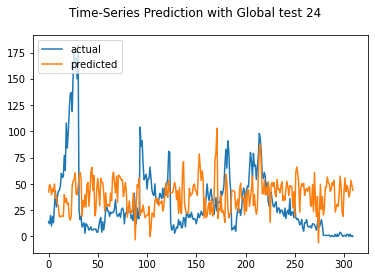

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 21.017
Test RMSE: 31.277
Test sMAPE: 71.890
Test R Squared: 0.014
{'mae': 21.017483908130277, 'rmse': 31.27665817304915, 'smape': 71.89011968557382, 'r2': 0.014002935822277407}


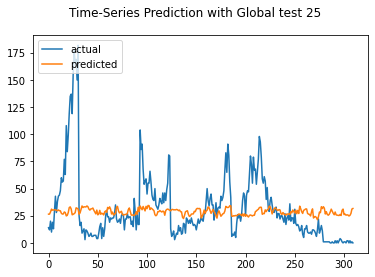

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 29.378
Test RMSE: 36.601
Test sMAPE: 87.149
Test R Squared: -0.350
{'mae': 29.37780924920113, 'rmse': 36.6006126004983, 'smape': 87.1488415763713, 'r2': -0.3502420949167444}


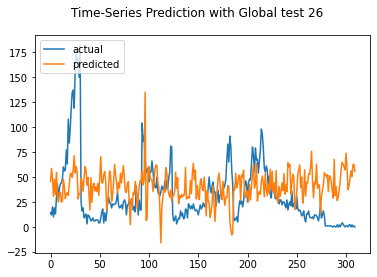

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 28.997
Test RMSE: 35.063
Test sMAPE: 84.488
Test R Squared: -0.239
{'mae': 28.996661647673577, 'rmse': 35.0626887774159, 'smape': 84.48752289756925, 'r2': -0.2391542426879829}


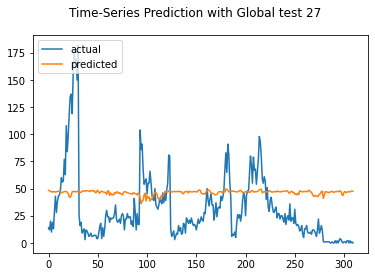

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 27.815
Test RMSE: 34.876
Test sMAPE: 81.840
Test R Squared: -0.226
{'mae': 27.81480135763845, 'rmse': 34.8759400308677, 'smape': 81.84031576918902, 'r2': -0.22598957976990186}


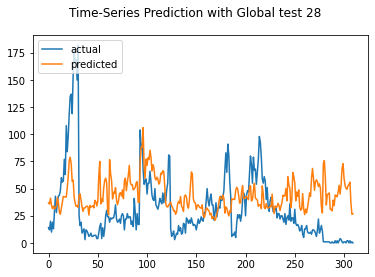

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 28.044
Test RMSE: 34.280
Test sMAPE: 83.063
Test R Squared: -0.184
{'mae': 28.043642708563034, 'rmse': 34.279626828876395, 'smape': 83.0634333554471, 'r2': -0.18442374523166594}


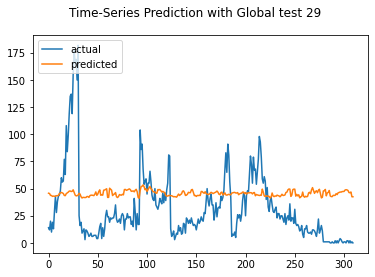

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 23.945
Test RMSE: 32.195
Test sMAPE: 77.150
Test R Squared: -0.045
{'mae': 23.94516079195084, 'rmse': 32.19461349259242, 'smape': 77.15018173389471, 'r2': -0.044723504493694666}


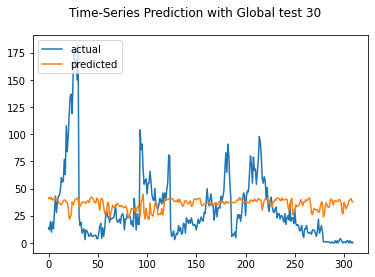

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 27.163
Test RMSE: 33.526
Test sMAPE: 81.718
Test R Squared: -0.133
{'mae': 27.16302848323699, 'rmse': 33.52648858713921, 'smape': 81.71820244662203, 'r2': -0.13295086159696767}


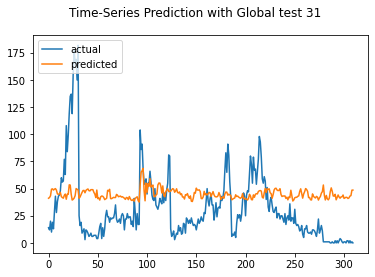

Test MAE: 39.567
Test RMSE: 50.087
Test sMAPE: 103.590
Test R Squared: -1.529
{'mae': 39.56673698084008, 'rmse': 50.0871521403398, 'smape': 103.5895452091681, 'r2': -1.528643547597932}


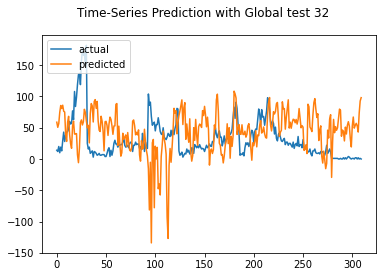

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 21.171
Test RMSE: 32.032
Test sMAPE: 73.826
Test R Squared: -0.034
{'mae': 21.17124878668016, 'rmse': 32.032138152592566, 'smape': 73.82556343289951, 'r2': -0.034205379040497474}


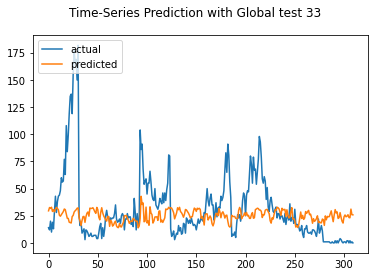

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 28.920
Test RMSE: 36.731
Test sMAPE: 89.354
Test R Squared: -0.360
{'mae': 28.91990743067957, 'rmse': 36.73148081366456, 'smape': 89.35432712356094, 'r2': -0.35991513951705745}


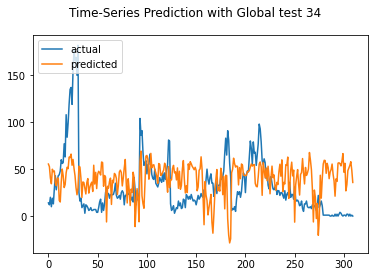

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 23.963
Test RMSE: 32.851
Test sMAPE: 77.854
Test R Squared: -0.088
{'mae': 23.962930390142624, 'rmse': 32.85053415753411, 'smape': 77.85357642649642, 'r2': -0.08772674192805363}


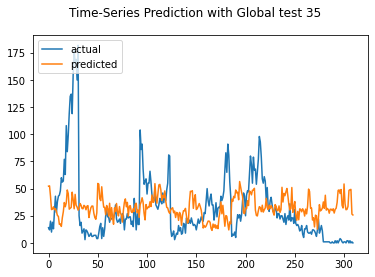

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 21.974
Test RMSE: 30.880
Test sMAPE: 72.399
Test R Squared: 0.039
{'mae': 21.973506035343295, 'rmse': 30.879780838871937, 'smape': 72.39880584241905, 'r2': 0.03886729992764881}


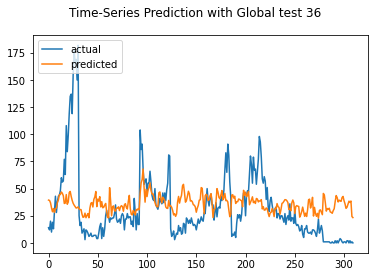

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 25.228
Test RMSE: 34.426
Test sMAPE: 80.155
Test R Squared: -0.195
{'mae': 25.22788946423079, 'rmse': 34.426353020673055, 'smape': 80.15509100918183, 'r2': -0.19458476082786302}


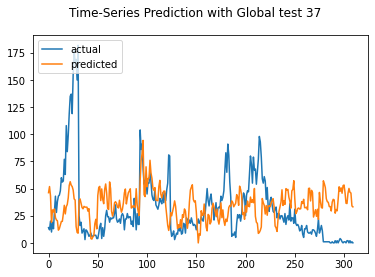

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 22.209
Test RMSE: 31.845
Test sMAPE: 74.105
Test R Squared: -0.022
{'mae': 22.20914644425915, 'rmse': 31.84480103963511, 'smape': 74.1052607875379, 'r2': -0.022143836433374586}


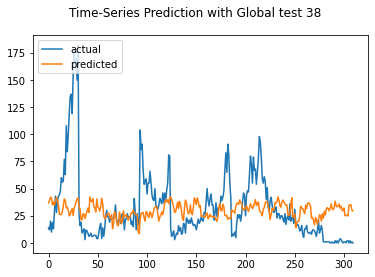

Test MAE: 32.863
Test RMSE: 40.580
Test sMAPE: 91.923
Test R Squared: -0.660
{'mae': 32.86277836676567, 'rmse': 40.580020085774116, 'smape': 91.92270710875826, 'r2': -0.6598141009184302}


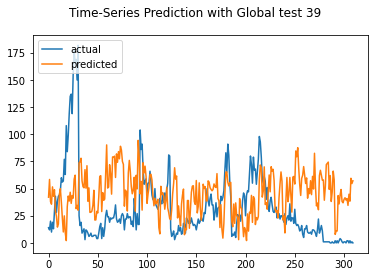

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 23.928
Test RMSE: 31.781
Test sMAPE: 77.818
Test R Squared: -0.018
{'mae': 23.927939741073118, 'rmse': 31.780980437743885, 'smape': 77.81824541945349, 'r2': -0.01805095692261549}


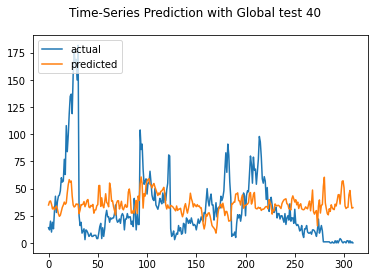

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 26.338
Test RMSE: 34.587
Test sMAPE: 82.818
Test R Squared: -0.206
{'mae': 26.338069097457392, 'rmse': 34.586968820514585, 'smape': 82.81761194227035, 'r2': -0.20575740921110386}


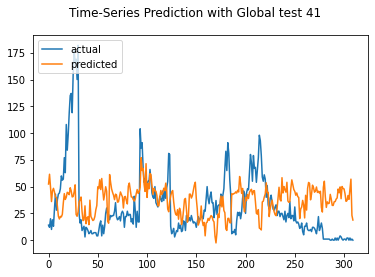

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 22.616
Test RMSE: 32.137
Test sMAPE: 77.334
Test R Squared: -0.041
{'mae': 22.615646617643296, 'rmse': 32.13657169827094, 'smape': 77.33364213950225, 'r2': -0.0409599577276456}


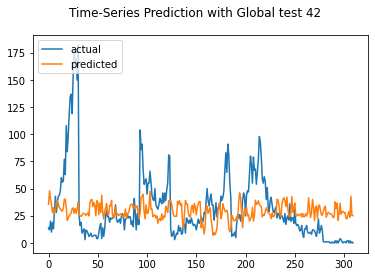

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 29.773
Test RMSE: 36.397
Test sMAPE: 86.414
Test R Squared: -0.335
{'mae': 29.773375248139903, 'rmse': 36.39737407838246, 'smape': 86.4139407853165, 'r2': -0.33528828537720234}


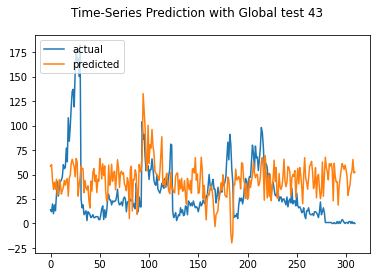

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 24.117
Test RMSE: 32.250
Test sMAPE: 76.579
Test R Squared: -0.048
{'mae': 24.116980109676238, 'rmse': 32.25048891593808, 'smape': 76.57852237044365, 'r2': -0.048352995121347275}


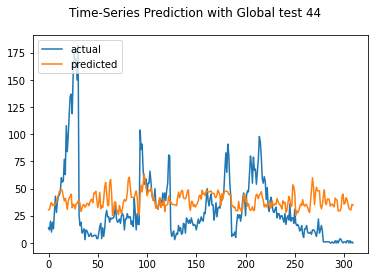

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 26.298
Test RMSE: 34.053
Test sMAPE: 82.143
Test R Squared: -0.169
{'mae': 26.297503611349292, 'rmse': 34.05307355457541, 'smape': 82.1429423231852, 'r2': -0.1688198199752069}


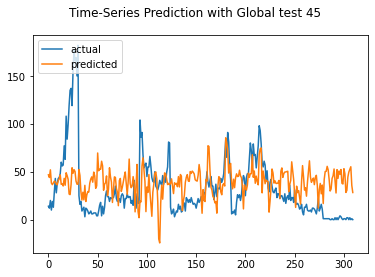

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 21.147
Test RMSE: 32.356
Test sMAPE: 72.625
Test R Squared: -0.055
{'mae': 21.147181775493006, 'rmse': 32.35617175183011, 'smape': 72.6254000851474, 'r2': -0.05523502711544315}


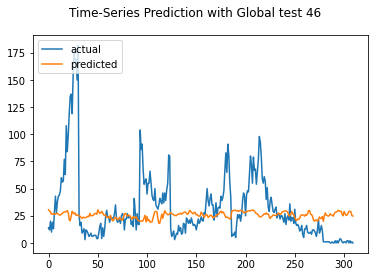

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 32.494
Test RMSE: 39.019
Test sMAPE: 89.945
Test R Squared: -0.535
{'mae': 32.49386559147989, 'rmse': 39.019367907888785, 'smape': 89.94506559843865, 'r2': -0.5346007074042392}


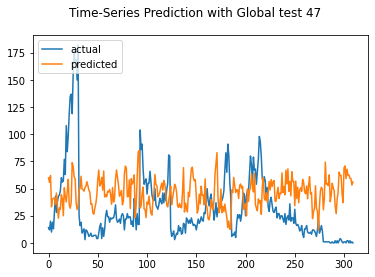

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 22.479
Test RMSE: 30.879
Test sMAPE: 73.734
Test R Squared: 0.039
{'mae': 22.478569756784747, 'rmse': 30.87868671957985, 'smape': 73.73393770773899, 'r2': 0.03893540761306802}


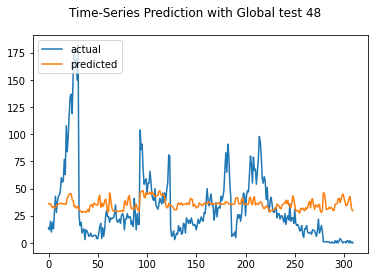

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 22.293
Test RMSE: 31.140
Test sMAPE: 73.825
Test R Squared: 0.023
{'mae': 22.292791151231334, 'rmse': 31.13953946764997, 'smape': 73.82460880442314, 'r2': 0.022629323004175306}


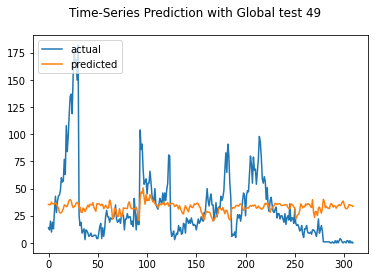

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 30.724
Test RMSE: 38.078
Test sMAPE: 87.343
Test R Squared: -0.461
{'mae': 30.72437833225535, 'rmse': 38.078290033693634, 'smape': 87.34311766808251, 'r2': -0.4614696786837258}


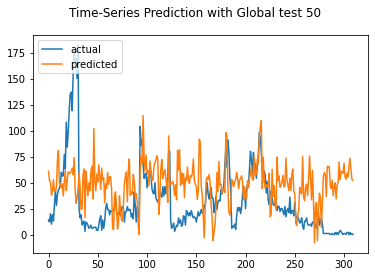

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 32.021
Test RMSE: 38.987
Test sMAPE: 86.053
Test R Squared: -0.532
{'mae': 32.020771721870666, 'rmse': 38.98650281402051, 'smape': 86.05252416810549, 'r2': -0.5320166800874411}


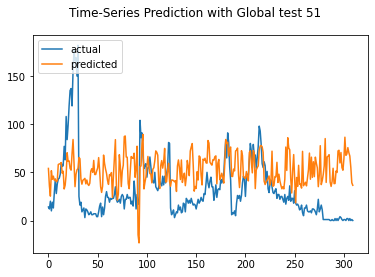

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 29.323
Test RMSE: 35.184
Test sMAPE: 84.894
Test R Squared: -0.248
{'mae': 29.32302536502961, 'rmse': 35.18391707280674, 'smape': 84.89374854535716, 'r2': -0.24773774005023652}


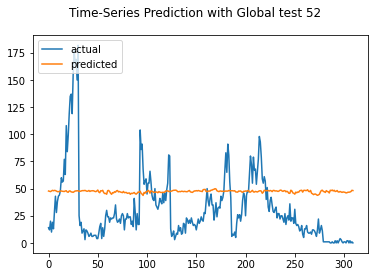

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 27.511
Test RMSE: 34.651
Test sMAPE: 83.320
Test R Squared: -0.210
{'mae': 27.511168443675963, 'rmse': 34.651340518515724, 'smape': 83.32021136378978, 'r2': -0.21024978785855963}


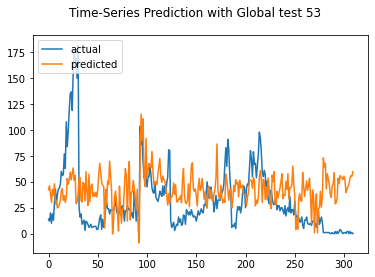

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 27.243
Test RMSE: 34.882
Test sMAPE: 81.061
Test R Squared: -0.226
{'mae': 27.24274567509851, 'rmse': 34.88246572021679, 'smape': 81.06053499642464, 'r2': -0.22644841618386935}


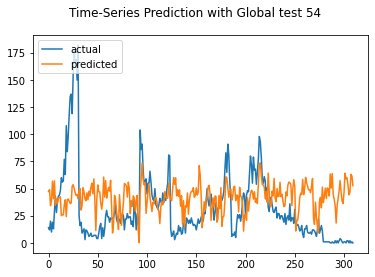

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 29.930
Test RMSE: 35.587
Test sMAPE: 85.585
Test R Squared: -0.276
{'mae': 29.929618257091892, 'rmse': 35.586510029594756, 'smape': 85.58463746273524, 'r2': -0.2764556562506373}


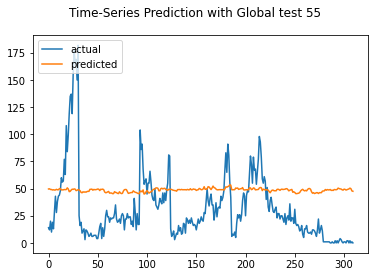

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 31.182
Test RMSE: 38.410
Test sMAPE: 85.171
Test R Squared: -0.487
{'mae': 31.182247022275003, 'rmse': 38.4095455080404, 'smape': 85.17063517551446, 'r2': -0.4870078837578218}


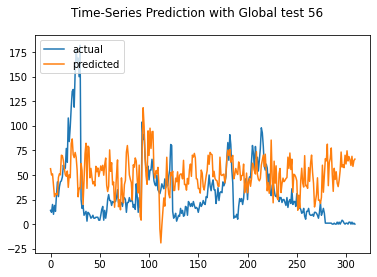

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 28.530
Test RMSE: 35.558
Test sMAPE: 86.825
Test R Squared: -0.274
{'mae': 28.529541464101882, 'rmse': 35.55803357239082, 'smape': 86.82532597591313, 'r2': -0.2744136245053759}


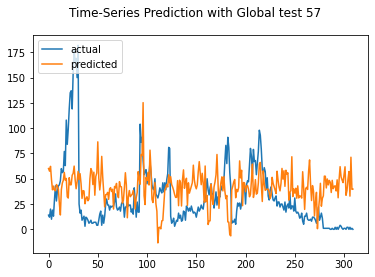

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 31.413
Test RMSE: 37.140
Test sMAPE: 87.186
Test R Squared: -0.390
{'mae': 31.41348073405604, 'rmse': 37.14019607063061, 'smape': 87.1860548075277, 'r2': -0.3903473670189468}


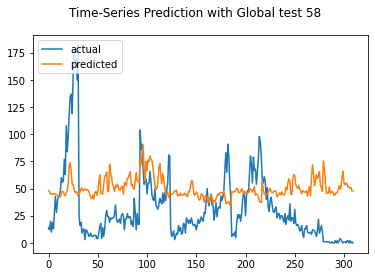

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 25.906
Test RMSE: 34.618
Test sMAPE: 84.362
Test R Squared: -0.208
{'mae': 25.90647339513225, 'rmse': 34.617882610620484, 'smape': 84.36188896182266, 'r2': -0.2079137814347376}


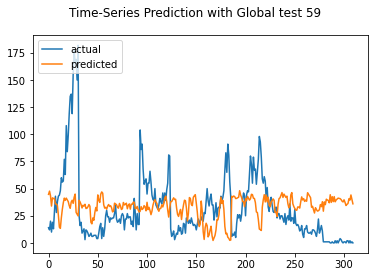

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 30.039
Test RMSE: 36.978
Test sMAPE: 83.835
Test R Squared: -0.378
{'mae': 30.039099957866053, 'rmse': 36.97814636611008, 'smape': 83.83540473309789, 'r2': -0.3782411382541919}


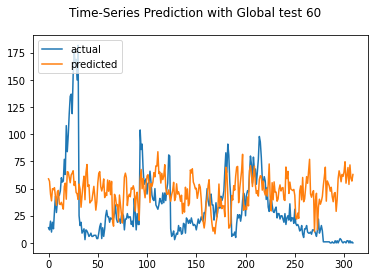

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 25.556
Test RMSE: 32.776
Test sMAPE: 79.507
Test R Squared: -0.083
{'mae': 25.55594708842616, 'rmse': 32.77560336731085, 'smape': 79.50677767860337, 'r2': -0.08277027638341217}


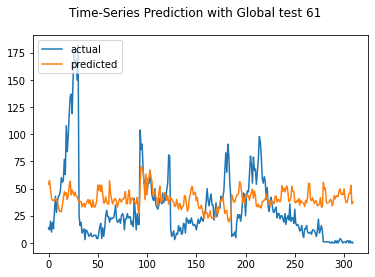

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 24.234
Test RMSE: 31.891
Test sMAPE: 77.445
Test R Squared: -0.025
{'mae': 24.233836143247544, 'rmse': 31.890850778625758, 'smape': 77.44491443957008, 'r2': -0.025102152274710132}


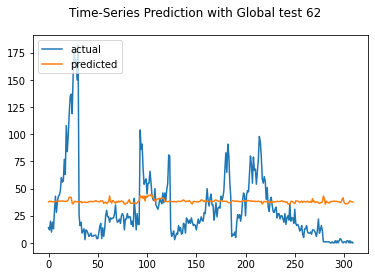

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 19.922
Test RMSE: 30.753
Test sMAPE: 68.261
Test R Squared: 0.047
{'mae': 19.92209721226846, 'rmse': 30.75306315442234, 'smape': 68.26130892762629, 'r2': 0.04673928698065255}


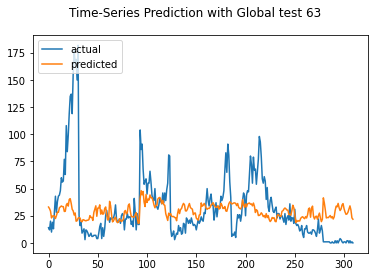

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 21.608
Test RMSE: 32.682
Test sMAPE: 75.085
Test R Squared: -0.077
{'mae': 21.608293850191178, 'rmse': 32.68155910801742, 'smape': 75.08471616521264, 'r2': -0.07656552478325462}


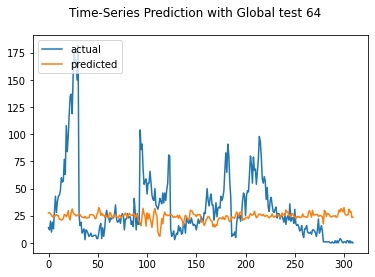

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 35.342
Test RMSE: 41.578
Test sMAPE: 91.214
Test R Squared: -0.742
{'mae': 35.34205058159367, 'rmse': 41.5775088421362, 'smape': 91.21446644457895, 'r2': -0.7424160532051616}


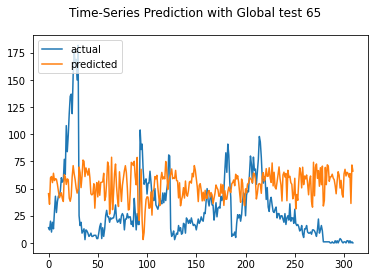

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 33.077
Test RMSE: 39.574
Test sMAPE: 90.871
Test R Squared: -0.579
{'mae': 33.077432087256064, 'rmse': 39.574251269565266, 'smape': 90.87056580665809, 'r2': -0.5785572904446334}


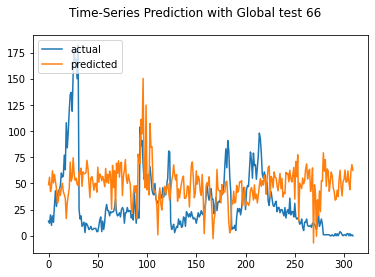

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 31.447
Test RMSE: 37.844
Test sMAPE: 86.241
Test R Squared: -0.444
{'mae': 31.44657741054412, 'rmse': 37.8438929816704, 'smape': 86.24135343883356, 'r2': -0.4435324325796617}


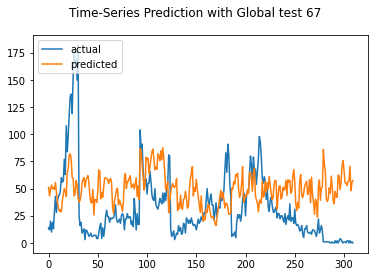

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 21.665
Test RMSE: 30.898
Test sMAPE: 73.037
Test R Squared: 0.038
{'mae': 21.665483160941832, 'rmse': 30.89773177126475, 'smape': 73.03732299003148, 'r2': 0.03774953014784277}


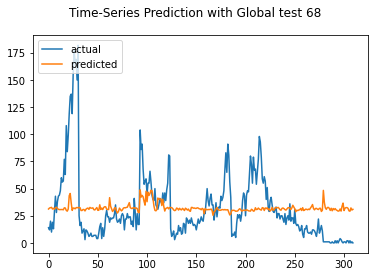

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 23.359
Test RMSE: 31.375
Test sMAPE: 75.441
Test R Squared: 0.008
{'mae': 23.359126312501967, 'rmse': 31.374518823377265, 'smape': 75.44096806534525, 'r2': 0.007823166468840848}


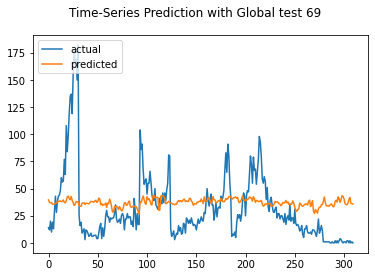

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 26.429
Test RMSE: 33.323
Test sMAPE: 80.202
Test R Squared: -0.119
{'mae': 26.42868224728492, 'rmse': 33.322533662557156, 'smape': 80.2020808405916, 'r2': -0.11920841082082712}


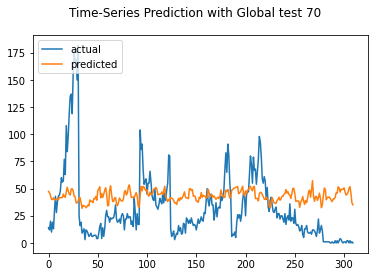

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 27.572
Test RMSE: 35.540
Test sMAPE: 81.691
Test R Squared: -0.273
{'mae': 27.57210105619123, 'rmse': 35.54033682534828, 'smape': 81.6908536119268, 'r2': -0.27314542370114436}


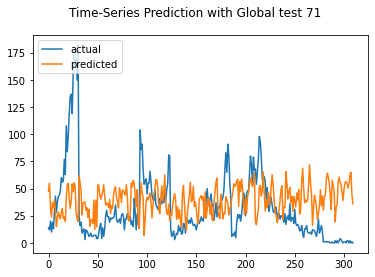

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 22.375
Test RMSE: 31.701
Test sMAPE: 74.780
Test R Squared: -0.013
{'mae': 22.374947701731035, 'rmse': 31.70128344316752, 'smape': 74.78015639355223, 'r2': -0.012951437095397145}


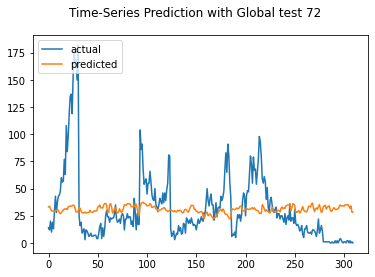

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 25.142
Test RMSE: 32.101
Test sMAPE: 78.488
Test R Squared: -0.039
{'mae': 25.14165692483225, 'rmse': 32.100621423777866, 'smape': 78.48782630226337, 'r2': -0.038632275443701625}


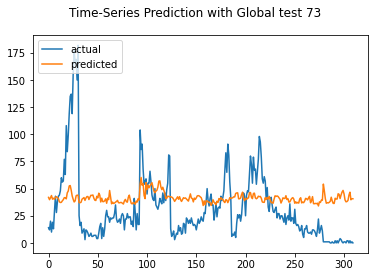

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 26.796
Test RMSE: 33.400
Test sMAPE: 81.268
Test R Squared: -0.124
{'mae': 26.79593978389617, 'rmse': 33.39993333613811, 'smape': 81.26828737484452, 'r2': -0.12441371555103675}


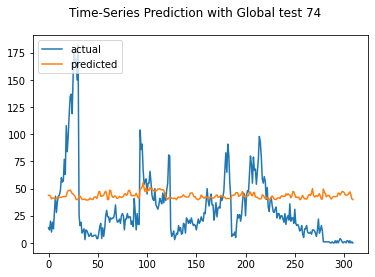

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 27.747
Test RMSE: 35.370
Test sMAPE: 90.098
Test R Squared: -0.261
{'mae': 27.747117711843984, 'rmse': 35.369874398158196, 'smape': 90.09774542113662, 'r2': -0.26096191489535836}


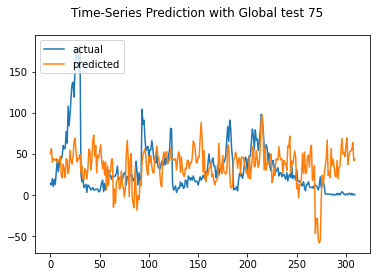

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 25.001
Test RMSE: 34.850
Test sMAPE: 85.172
Test R Squared: -0.224
{'mae': 25.001083861051068, 'rmse': 34.85024763397478, 'smape': 85.17178359882013, 'r2': -0.22418392184936264}


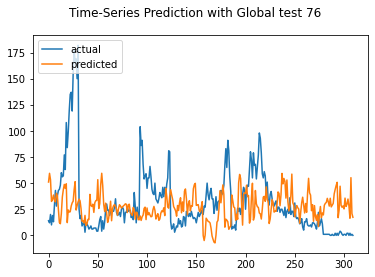

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 21.469
Test RMSE: 30.998
Test sMAPE: 72.747
Test R Squared: 0.031
{'mae': 21.46918554613667, 'rmse': 30.998036849011694, 'smape': 72.74671093766224, 'r2': 0.03149177143264581}


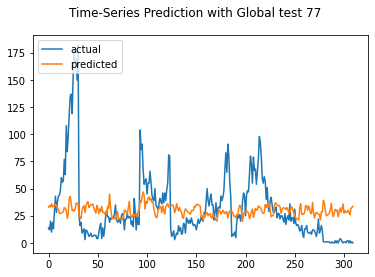

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 23.437
Test RMSE: 31.850
Test sMAPE: 78.358
Test R Squared: -0.022
{'mae': 23.436643551241968, 'rmse': 31.84956212802589, 'smape': 78.3583773245088, 'r2': -0.02244949894586168}


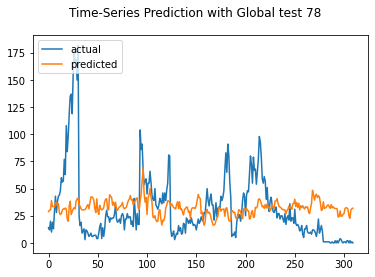

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 31.795
Test RMSE: 39.426
Test sMAPE: 88.352
Test R Squared: -0.567
{'mae': 31.794812005566012, 'rmse': 39.42596507422802, 'smape': 88.35211032939682, 'r2': -0.566749627772482}


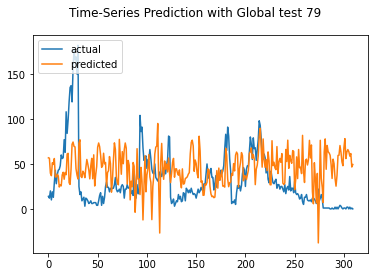

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 22.675
Test RMSE: 33.343
Test sMAPE: 80.822
Test R Squared: -0.121
{'mae': 22.67461814438143, 'rmse': 33.343480369090315, 'smape': 80.82158614271667, 'r2': -0.12061593275716698}


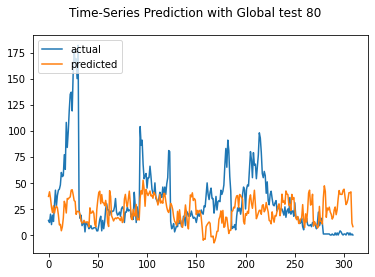

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 23.161
Test RMSE: 31.431
Test sMAPE: 76.298
Test R Squared: 0.004
{'mae': 23.160562176858225, 'rmse': 31.430836715319437, 'smape': 76.29808697294185, 'r2': 0.004258014859126913}


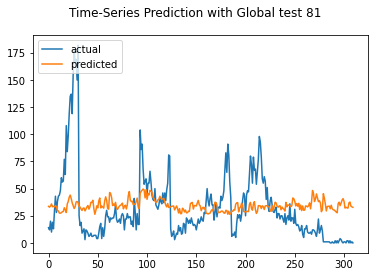

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 22.938
Test RMSE: 32.987
Test sMAPE: 78.858
Test R Squared: -0.097
{'mae': 22.938024878117346, 'rmse': 32.98720490198723, 'smape': 78.85783318823593, 'r2': -0.09679628489996484}


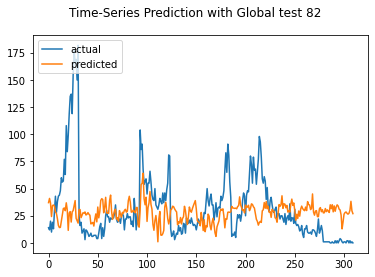

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 30.465
Test RMSE: 36.685
Test sMAPE: 87.082
Test R Squared: -0.356
{'mae': 30.46498097027502, 'rmse': 36.6850872140112, 'smape': 87.0815225630712, 'r2': -0.3564820345367048}


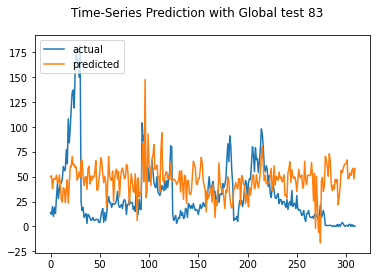

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 25.783
Test RMSE: 32.683
Test sMAPE: 79.781
Test R Squared: -0.077
{'mae': 25.783351984331684, 'rmse': 32.682610066528326, 'smape': 79.78065338340204, 'r2': -0.07663476529219171}


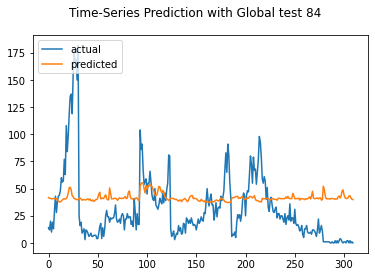

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 29.088
Test RMSE: 37.715
Test sMAPE: 86.756
Test R Squared: -0.434
{'mae': 29.088420903586574, 'rmse': 37.71458377508058, 'smape': 86.75626049157957, 'r2': -0.4336844431101452}


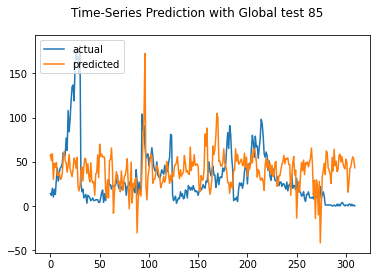

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 28.034
Test RMSE: 35.119
Test sMAPE: 83.817
Test R Squared: -0.243
{'mae': 28.033778809539733, 'rmse': 35.11864906566117, 'smape': 83.81660384746007, 'r2': -0.24311279619949833}


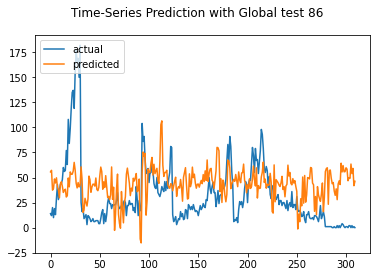

Test MAE: 30.261
Test RMSE: 39.533
Test sMAPE: 89.303
Test R Squared: -0.575
{'mae': 30.261384546949017, 'rmse': 39.532677473217426, 'smape': 89.30300460320926, 'r2': -0.5752424002843133}


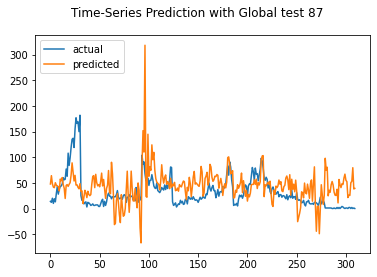

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 23.020
Test RMSE: 32.475
Test sMAPE: 76.912
Test R Squared: -0.063
{'mae': 23.019664998208324, 'rmse': 32.47523357913026, 'smape': 76.91223643618336, 'r2': -0.06301526567905946}


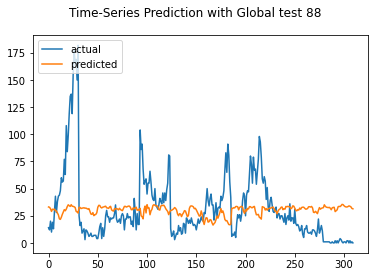

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 31.465
Test RMSE: 37.016
Test sMAPE: 87.053
Test R Squared: -0.381
{'mae': 31.465361035254695, 'rmse': 37.01580905237109, 'smape': 87.05311997695286, 'r2': -0.38105007830558835}


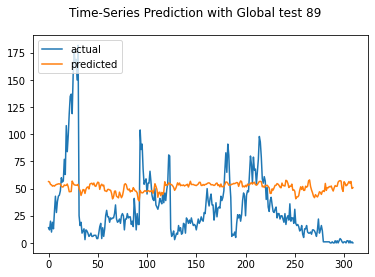

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 29.217
Test RMSE: 36.255
Test sMAPE: 84.097
Test R Squared: -0.325
{'mae': 29.217219408096806, 'rmse': 36.25498032454902, 'smape': 84.09680576438495, 'r2': -0.32486089659287076}


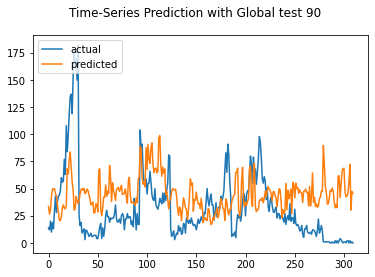

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 30.440
Test RMSE: 37.652
Test sMAPE: 85.346
Test R Squared: -0.429
{'mae': 30.44036969215639, 'rmse': 37.652271114084456, 'smape': 85.34559895327578, 'r2': -0.42895084236681447}


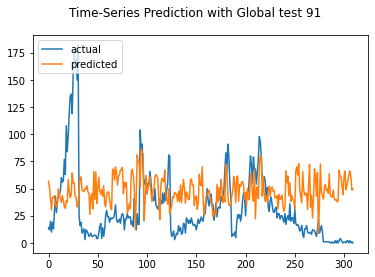

Test MAE: 36.683
Test RMSE: 45.640
Test sMAPE: 93.986
Test R Squared: -1.100
{'mae': 36.683317124651325, 'rmse': 45.64035364945884, 'smape': 93.98555642486109, 'r2': -1.0995824617949466}


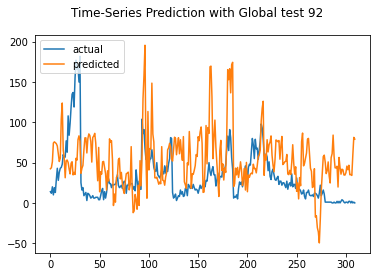

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 28.229
Test RMSE: 35.569
Test sMAPE: 82.731
Test R Squared: -0.275
{'mae': 28.229132843017577, 'rmse': 35.56855496722174, 'smape': 82.73125614705002, 'r2': -0.2751679177738635}


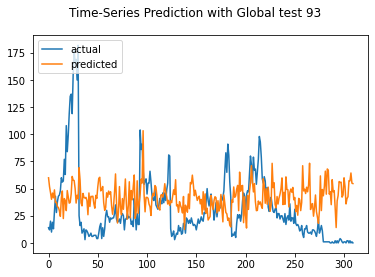

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 31.064
Test RMSE: 37.862
Test sMAPE: 86.798
Test R Squared: -0.445
{'mae': 31.06424118415002, 'rmse': 37.862078285329126, 'smape': 86.79789526187194, 'r2': -0.44492010075200006}


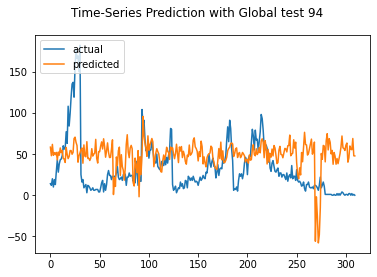

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 24.022
Test RMSE: 32.171
Test sMAPE: 79.639
Test R Squared: -0.043
{'mae': 24.022326590937954, 'rmse': 32.17094790203733, 'smape': 79.63899425947882, 'r2': -0.0431881599766506}


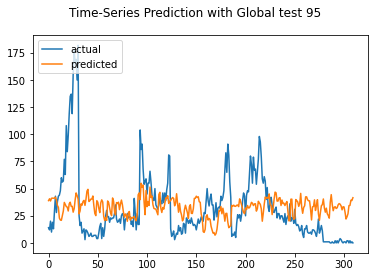

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 29.449
Test RMSE: 35.875
Test sMAPE: 84.536
Test R Squared: -0.297
{'mae': 29.44890452546458, 'rmse': 35.874860214245324, 'smape': 84.5356349326628, 'r2': -0.29722517854405583}


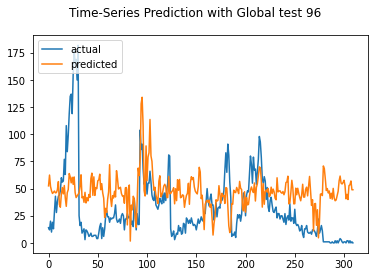

Test MAE: 33.267
Test RMSE: 40.766
Test sMAPE: 92.743
Test R Squared: -0.675
{'mae': 33.26741428279107, 'rmse': 40.76605127546994, 'smape': 92.74304122776458, 'r2': -0.6750671715491796}


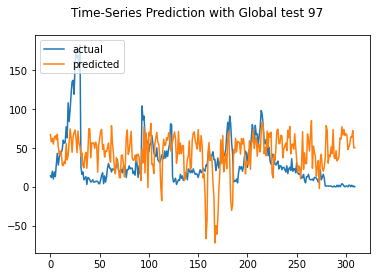

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 21.234
Test RMSE: 33.299
Test sMAPE: 73.779
Test R Squared: -0.118
{'mae': 21.23371134727232, 'rmse': 33.2993884428603, 'smape': 73.77893949215192, 'r2': -0.11765418757458312}


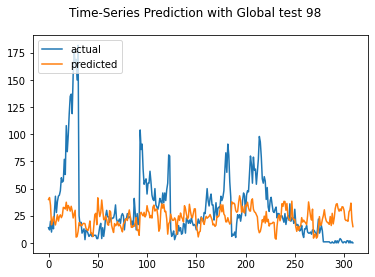

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 24.480
Test RMSE: 33.466
Test sMAPE: 75.654
Test R Squared: -0.129
{'mae': 24.48049927680723, 'rmse': 33.46577777173963, 'smape': 75.65420508588122, 'r2': -0.1288514108715333}


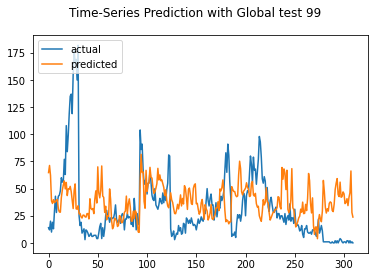

rmse : average=35.479, std=3.984
mae : average=27.496, std=4.337
smape : average=83.094, std=7.628
r2 : average=-0.285, std=0.311


([35.478692322164264, 3.9839670551719766],
 [27.495892032060528, 4.337134825964427],
 [83.09408798909978, 7.628406658544026],
 [-0.2847307540476769, 0.3105250412269786])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')